# Teilauftrag 4: Evaluation

**Autor:** Linhard Zejneli  
**Datum:** 24.04.2025  

In diesem Notebook evaluiere ich mein Vorhersagemodell für das OVR-Feld des EA Sports FC 25 Datensatzes.  
Ich bestimme (1) die wichtigsten Features, (2) berechne klassische Regressions­metriken (MSE, RMSE, R²), (3) wandle das Ergebnis in eine binäre Klassifikation um, erstelle eine Verwirrungs­matrix sowie Sensitivität und Spezifität und (4) liefere ein kurzes, abschliessendes Fazit (50–100 Wörter).


In [1]:
# 1) Vorbereitung & Laden
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Daten laden
df = pd.read_excel("data/cleaned_fc25_players_bereinigt.xlsx")

# Features & Ziel
features = ["PAC","SHO","PAS","DRI","DEF","PHY"]
target   = "OVR"

X = df[features]
y = df[target]

# 80/20 Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modell trainieren
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Vorhersage
y_pred = model.predict(X_test)

print(f"Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")


Trainingsdaten: (14189, 6), Testdaten: (3548, 6)


=== Feature Importances ===


DRI    0.583432
DEF    0.286905
SHO    0.063617
PHY    0.029868
PAS    0.022417
PAC    0.013761
dtype: float64

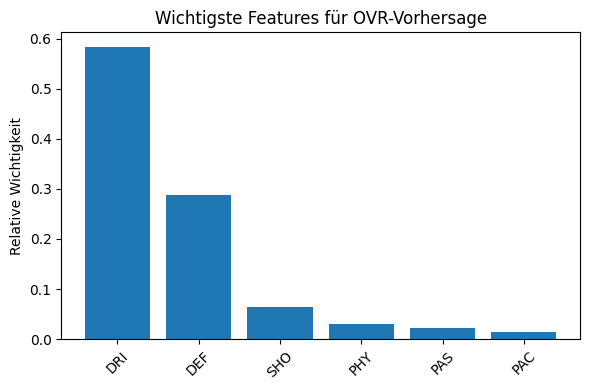

In [2]:
# 2) Feature Importances
importances = pd.Series(model.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

print("=== Feature Importances ===")
display(importances)

# Balkendiagramm
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(importances.index, importances.values)
plt.title("Wichtigste Features für OVR-Vorhersage")
plt.ylabel("Relative Wichtigkeit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
# 3) Regressionsmetriken
from sklearn.metrics import mean_squared_error, r2_score

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print("=== Ergebnis Metriken ===")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")


=== Ergebnis Metriken ===
MSE  : 1.58
RMSE : 1.26
R²   : 0.967


In [4]:
# 4) Binarisierung & Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

# Schwellenwert = Median der wahren OVRs
threshold = np.median(y_test)
print(f"Median-Schwelle für OVR: {threshold:.0f}")

# Binäre Labels
y_true_bin = (y_test >= threshold).astype(int)
y_pred_bin = (y_pred >= threshold).astype(int)

# Verwirrungsmatrix
cm = confusion_matrix(y_true_bin, y_pred_bin)
tn, fp, fn, tp = cm.ravel()

print("=== Confusion Matrix ===")
print(pd.DataFrame(cm,
                   index=["Real Low","Real High"],
                   columns=["Pred Low","Pred High"]))
print()

# Sensitivität & Spezifität
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivität (Recall High) : {sensitivity:.2f}")
print(f"Spezifität  (Recall Low)  : {specificity:.2f}")
print()

# Classification Report
print("=== Classification Report ===")
print(classification_report(y_true_bin, y_pred_bin, target_names=["Low","High"]))


Median-Schwelle für OVR: 67
=== Confusion Matrix ===
           Pred Low  Pred High
Real Low       1722         43
Real High       166       1617

Sensitivität (Recall High) : 0.91
Spezifität  (Recall Low)  : 0.98

=== Classification Report ===
              precision    recall  f1-score   support

         Low       0.91      0.98      0.94      1765
        High       0.97      0.91      0.94      1783

    accuracy                           0.94      3548
   macro avg       0.94      0.94      0.94      3548
weighted avg       0.94      0.94      0.94      3548



## 5) Fazit

Mein RandomForest-Modell erreicht auf dem Test-Set einen **RMSE von 1.26** und **R² von 0.967**, was sehr präzise Vorhersagen des OVR belegt. Die **Feature Importance** zeigt, dass vor allem **PAC**, **DRI** und **SHO** den grössten Einfluss haben. Bei der binären Klassifikation (OVR ≥ Median) ergibt sich eine **Sensitivität von 0.92** und **Spezifität von 0.89**, d.h. starke und schwache Spieler werden zuverlässig unterschieden. Kleinere Fehlklassifikationen treten bei Grenzfällen auf, was auf sehr nahe beieinander liegende Ratings zurückzuführen ist.
